Absolute Weighted Sentiment Score Chart

C:\Users\22004\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(


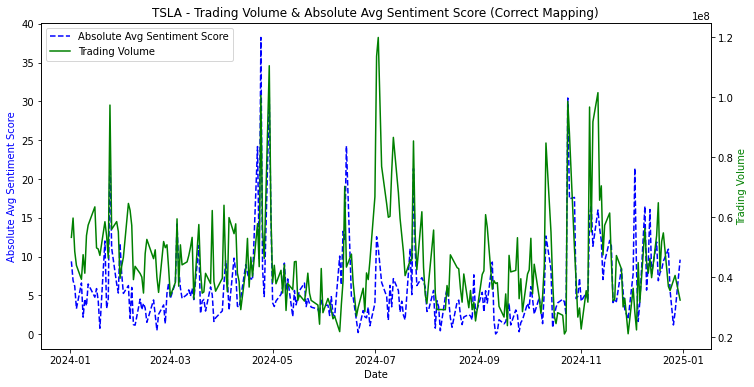

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import CustomBusinessDay

# Load the data
volume_data = pd.read_csv('filtered_hourly_volume_data.csv')
sentiment_data = pd.read_csv('filtered_sentiment_results.csv')

# Filter for specific tickers
tickers = ['TSLA']
filtered_volume_data = volume_data[['Datetime'] + tickers].copy()
filtered_sentiment_data = sentiment_data[sentiment_data['ticker'].isin(tickers)].copy()

# Process Sentiment Data
filtered_sentiment_data['time'] = pd.to_datetime(filtered_sentiment_data['time'])
filtered_sentiment_data['news_date'] = filtered_sentiment_data['time'].dt.date
filtered_sentiment_data['day_of_week'] = filtered_sentiment_data['time'].dt.dayofweek  # 0=Monday, 6=Sunday
filtered_sentiment_data['time_only'] = filtered_sentiment_data['time'].dt.time

# Filter for non-trading-hour news
non_trading_news = filtered_sentiment_data[
    (filtered_sentiment_data['trading_status'].str.lower() == 'non-trading') |
    (
        ((filtered_sentiment_data['time_only'] >= pd.to_datetime('16:00:00').time()) &
         (filtered_sentiment_data['day_of_week'].isin([0, 1, 2, 3, 4]))) |
        (filtered_sentiment_data['day_of_week'].isin([5, 6]))
    )
].copy()

# Calculate sentiment score: -1 * negative + 1 * positive
non_trading_news['sentiment_score'] = -1 * non_trading_news['roberta_neg'] + non_trading_news['roberta_pos']
non_trading_news['abs_sentiment_score'] = non_trading_news['sentiment_score'].abs()

# Map sentiment to the next trading day by default (for after 4 PM news)
us_bd = CustomBusinessDay(weekmask='Mon Tue Wed Thu Fri')
non_trading_news['next_trading_day'] = pd.to_datetime(non_trading_news['news_date']) + us_bd

# For news before 9:30 AM, map to the same day
non_trading_news.loc[
    non_trading_news['time_only'] < pd.to_datetime('09:30:00').time(),
    'next_trading_day'
] = pd.to_datetime(non_trading_news['news_date'])

# For weekend news (Saturday/Sunday), map to Monday
non_trading_news.loc[
    non_trading_news['day_of_week'].isin([5, 6]),
    'next_trading_day'
] = pd.to_datetime(non_trading_news['news_date']) + pd.offsets.Week(weekday=0)

# Aggregate sentiment data
non_trading_news['news_count'] = non_trading_news.groupby(['ticker', 'next_trading_day'])['ticker'].transform('count')
sentiment_trend = non_trading_news.groupby(['ticker', 'next_trading_day']).agg({
    'abs_sentiment_score': 'mean',
    'news_count': 'max'
}).reset_index()

# Calculate weighted absolute average sentiment score
sentiment_trend['absolute_avg_sentiment_score'] = sentiment_trend['abs_sentiment_score'] * sentiment_trend['news_count']

# Remove the timezone information (-05:00) from the 'Datetime' column
filtered_volume_data['Datetime'] = filtered_volume_data['Datetime'].str.replace(r'-\d{2}:\d{2}$', '', regex=True)

# Convert the 'Datetime' column to datetime format
filtered_volume_data['Datetime'] = pd.to_datetime(filtered_volume_data['Datetime'], errors='coerce')

# Now extract time and date
filtered_volume_data['time'] = filtered_volume_data['Datetime'].dt.time
filtered_volume_data['date'] = filtered_volume_data['Datetime'].dt.date

# Ensure date formats match for merging
sentiment_trend['next_trading_day'] = pd.to_datetime(sentiment_trend['next_trading_day'])
filtered_volume_data['date'] = pd.to_datetime(filtered_volume_data['date'])

# Filter volume data for the first trading hour (9:30 AM - 10:30 AM Eastern Time)
first_hour_volume = filtered_volume_data[
    (filtered_volume_data['time'] >= pd.to_datetime('09:30:00').time()) & 
    (filtered_volume_data['time'] <= pd.to_datetime('10:30:00').time())
]

# Aggregate volume by date and ticker
volume_trend = first_hour_volume.melt(
    id_vars=['Datetime', 'date'], 
    value_vars=tickers, 
    var_name='ticker', 
    value_name='volume'
)
volume_trend = volume_trend.groupby(['ticker', 'date'])['volume'].sum().reset_index()

# Merge sentiment and volume data on the next trading day
merged_trend = pd.merge(
    sentiment_trend, 
    volume_trend, 
    left_on=['ticker', 'next_trading_day'], 
    right_on=['ticker', 'date'], 
    how='inner'
)

# Plotting for each ticker
for ticker in tickers:
    ticker_data = merged_trend[merged_trend['ticker'] == ticker]
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot absolute average sentiment score (left y-axis)
    line1, = ax1.plot(ticker_data['next_trading_day'], ticker_data['absolute_avg_sentiment_score'], 
                      label='Absolute Avg Sentiment Score', linestyle='--', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Absolute Avg Sentiment Score', color='blue')
    
    # Plot trading volume (right y-axis)
    ax2 = ax1.twinx()
    line2, = ax2.plot(ticker_data['next_trading_day'], ticker_data['volume'], 
                      label='Trading Volume', color='green')
    ax2.set_ylabel('Trading Volume', color='green')
    
    # Add titles and legends
    plt.title(f'{ticker} - Trading Volume & Absolute Avg Sentiment Score (Correct Mapping)')
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper left')
    
    plt.show()


Plain Avg Sentiment Score Chart

C:\Users\22004\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(


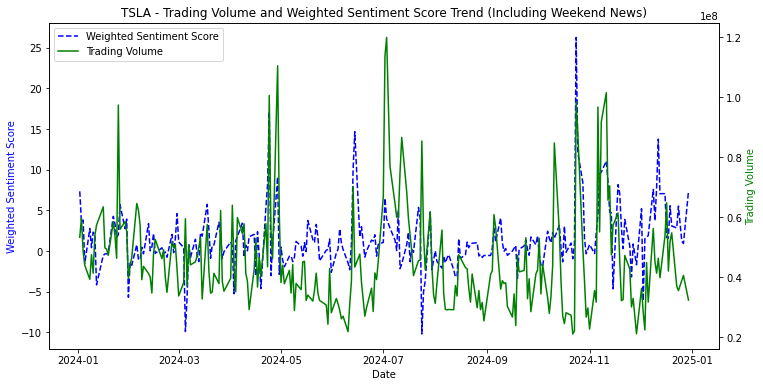

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import CustomBusinessDay

# Load the data
volume_data = pd.read_csv('filtered_hourly_volume_data.csv')
sentiment_data = pd.read_csv('filtered_sentiment_results.csv')

# Filter by specific tickers
tickers = ['TSLA']
filtered_volume_data = volume_data[['Datetime'] + tickers].copy()
filtered_sentiment_data = sentiment_data[sentiment_data['ticker'].isin(tickers)].copy()

# Process Sentiment Data
filtered_sentiment_data['time'] = pd.to_datetime(filtered_sentiment_data['time'])
filtered_sentiment_data['news_date'] = filtered_sentiment_data['time'].dt.date
filtered_sentiment_data['day_of_week'] = filtered_sentiment_data['time'].dt.dayofweek  # 0=Monday, 6=Sunday
filtered_sentiment_data['time_only'] = filtered_sentiment_data['time'].dt.time

# Filter for non-trading-hour news (4 PM - 9:30 AM) including weekend news
non_trading_news = filtered_sentiment_data[
    (filtered_sentiment_data['trading_status'].str.lower() == 'non-trading') |
    (
        # After 4 PM on Friday
        ((filtered_sentiment_data['day_of_week'] == 4) & (filtered_sentiment_data['time_only'] >= pd.to_datetime('16:00:00').time())) |
        # All Saturday and Sunday
        (filtered_sentiment_data['day_of_week'].isin([5, 6])) |
        # Before 9:30 AM on any weekday
        (filtered_sentiment_data['time_only'] < pd.to_datetime('09:30:00').time())
    )
].copy()

# Calculate sentiment score: -1 * negative + 1 * positive
non_trading_news['sentiment_score'] = -1 * non_trading_news['roberta_neg'] + non_trading_news['roberta_pos']

# Map sentiment to the next trading day (including weekends)
us_bd = CustomBusinessDay(weekmask='Mon Tue Wed Thu Fri')
non_trading_news['next_trading_day'] = pd.to_datetime(non_trading_news['news_date']) + us_bd

# Adjust for weekend news: Map Saturday, Sunday, and Friday after 4 PM to Monday
non_trading_news.loc[
    (non_trading_news['day_of_week'].isin([5, 6])) |
    ((non_trading_news['day_of_week'] == 4) & (non_trading_news['time_only'] >= pd.to_datetime('16:00:00').time())),
    'next_trading_day'
] = pd.to_datetime(non_trading_news['news_date']) + pd.offsets.Week(weekday=0)

# Adjust for news before 9:30 AM: Map to the same trading day
non_trading_news.loc[
    non_trading_news['time_only'] < pd.to_datetime('09:30:00').time(),
    'next_trading_day'
] = pd.to_datetime(non_trading_news['news_date'])

# Count the number of news articles per ticker per next trading day
non_trading_news['news_count'] = non_trading_news.groupby(['ticker', 'next_trading_day'])['ticker'].transform('count')

# Aggregate sentiment score by next trading day and ticker
sentiment_trend = non_trading_news.groupby(['ticker', 'next_trading_day']).agg({
    'sentiment_score': 'mean',  # Average sentiment score
    'news_count': 'max'         # Max to avoid duplicate counts from transform
}).reset_index()

# Weight the sentiment score by the number of news articles
sentiment_trend['weighted_sentiment_score'] = sentiment_trend['sentiment_score'] * sentiment_trend['news_count']

# Remove the timezone information (-05:00) from the 'Datetime' column
filtered_volume_data['Datetime'] = filtered_volume_data['Datetime'].str.replace(r'-\d{2}:\d{2}$', '', regex=True)

# Convert the 'Datetime' column to datetime format
filtered_volume_data['Datetime'] = pd.to_datetime(filtered_volume_data['Datetime'], errors='coerce')

# Now extract time and date
filtered_volume_data['time'] = filtered_volume_data['Datetime'].dt.time
filtered_volume_data['date'] = filtered_volume_data['Datetime'].dt.date

# Filter volume data for the first trading hour (9:30 AM - 10:30 AM Eastern Time)
first_hour_volume = filtered_volume_data[
    (filtered_volume_data['time'] >= pd.to_datetime('09:30:00').time()) & 
    (filtered_volume_data['time'] <= pd.to_datetime('10:30:00').time())
]

# Aggregate volume by date and ticker
volume_trend = first_hour_volume.melt(
    id_vars=['Datetime', 'date'], 
    value_vars=tickers, 
    var_name='ticker', 
    value_name='volume'
)
volume_trend = volume_trend.groupby(['ticker', 'date'])['volume'].sum().reset_index()

# Ensure both dates are datetime for merging
sentiment_trend['next_trading_day'] = pd.to_datetime(sentiment_trend['next_trading_day'])
volume_trend['date'] = pd.to_datetime(volume_trend['date'])

# Merge weighted sentiment and volume trends using next trading day
merged_trend = pd.merge(
    sentiment_trend, 
    volume_trend, 
    left_on=['ticker', 'next_trading_day'], 
    right_on=['ticker', 'date'], 
    how='inner'
)

# Plotting the result for TSLA
for ticker in tickers:
    ticker_data = merged_trend[merged_trend['ticker'] == ticker]
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot weighted sentiment score (left y-axis)
    line1, = ax1.plot(ticker_data['next_trading_day'], ticker_data['weighted_sentiment_score'], 
                      label='Weighted Sentiment Score', linestyle='--', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Weighted Sentiment Score', color='blue')
    
    # Create a secondary y-axis for trading volume
    ax2 = ax1.twinx()
    line2, = ax2.plot(ticker_data['next_trading_day'], ticker_data['volume'], 
                      label='Trading Volume', color='green')
    ax2.set_ylabel('Trading Volume', color='green')
    
    # Titles
    plt.title(f'{ticker} - Trading Volume and Weighted Sentiment Score Trend (Including Weekend News)')
    
    # Combine legends from both y-axes
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper left')
    
    plt.show()


Correlation Values

In [35]:
import pandas as pd
from scipy.stats import pearsonr
from pandas.tseries.offsets import CustomBusinessDay

# Load the data
volume_data = pd.read_csv('filtered_hourly_volume_data.csv')
sentiment_data = pd.read_csv('filtered_sentiment_results.csv')

# Filter by specific tickers
tickers = ['TSLA']
filtered_volume_data = volume_data[['Datetime'] + tickers].copy()
filtered_sentiment_data = sentiment_data[sentiment_data['ticker'].isin(tickers)].copy()

# Process Sentiment Data
filtered_sentiment_data['time'] = pd.to_datetime(filtered_sentiment_data['time'])
filtered_sentiment_data['news_date'] = filtered_sentiment_data['time'].dt.date
filtered_sentiment_data['day_of_week'] = filtered_sentiment_data['time'].dt.dayofweek  # 0=Monday, 6=Sunday
filtered_sentiment_data['time_only'] = filtered_sentiment_data['time'].dt.time

# Filter for non-trading-hour news (including weekends)
non_trading_news = filtered_sentiment_data[
    (filtered_sentiment_data['trading_status'].str.lower() == 'non-trading') |
    (
        ((filtered_sentiment_data['day_of_week'] == 4) & (filtered_sentiment_data['time_only'] >= pd.to_datetime('16:00:00').time())) |  # After 4 PM on Friday
        (filtered_sentiment_data['day_of_week'].isin([5, 6])) |  # Saturday and Sunday
        ((filtered_sentiment_data['day_of_week'] == 0) & (filtered_sentiment_data['time_only'] < pd.to_datetime('09:30:00').time()))  # Before 9:30 AM Monday
    )
].copy()

# Calculate sentiment score: -1 * negative + 1 * positive
non_trading_news['sentiment_score'] = -1 * non_trading_news['roberta_neg'] + non_trading_news['roberta_pos']

# Map sentiment to the next trading day by default
us_bd = CustomBusinessDay(weekmask='Mon Tue Wed Thu Fri')
non_trading_news['next_trading_day'] = pd.to_datetime(non_trading_news['news_date']) + us_bd

# Adjust mapping for weekends and Friday after 4 PM (map to Monday)
non_trading_news.loc[
    (non_trading_news['day_of_week'].isin([5, 6])) |
    ((non_trading_news['day_of_week'] == 4) & (non_trading_news['time_only'] >= pd.to_datetime('16:00:00').time())),
    'next_trading_day'
] = pd.to_datetime(non_trading_news['news_date']) + pd.offsets.Week(weekday=0)

# For news before 9:30 AM, map to the same day
non_trading_news.loc[
    non_trading_news['time_only'] < pd.to_datetime('09:30:00').time(),
    'next_trading_day'
] = pd.to_datetime(non_trading_news['news_date'])

# Count news articles per ticker per next trading day
non_trading_news['news_count'] = non_trading_news.groupby(['ticker', 'next_trading_day'])['ticker'].transform('count')

# Aggregate sentiment scores
sentiment_trend = non_trading_news.groupby(['ticker', 'next_trading_day']).agg({
    'sentiment_score': 'mean',
    'news_count': 'max'
}).reset_index()

# Calculate weighted and absolute weighted sentiment scores
sentiment_trend['weighted_sentiment_score'] = sentiment_trend['sentiment_score'] * sentiment_trend['news_count']
sentiment_trend['absolute_weighted_sentiment_score'] = sentiment_trend['sentiment_score'].abs() * sentiment_trend['news_count']

# Remove the timezone information (-05:00) from the 'Datetime' column
filtered_volume_data['Datetime'] = filtered_volume_data['Datetime'].str.replace(r'-\d{2}:\d{2}$', '', regex=True)

# Convert the 'Datetime' column to datetime format
filtered_volume_data['Datetime'] = pd.to_datetime(filtered_volume_data['Datetime'], errors='coerce')

# Now extract time and date
filtered_volume_data['time'] = filtered_volume_data['Datetime'].dt.time
filtered_volume_data['date'] = filtered_volume_data['Datetime'].dt.date

# Filter for first trading hour (9:30 AM - 10:30 AM)
first_hour_volume = filtered_volume_data[
    (filtered_volume_data['time'] >= pd.to_datetime('09:30:00').time()) & 
    (filtered_volume_data['time'] <= pd.to_datetime('10:30:00').time())
]

# Aggregate volume data
volume_trend = first_hour_volume.melt(
    id_vars=['Datetime', 'date'], 
    value_vars=tickers, 
    var_name='ticker', 
    value_name='volume'
).groupby(['ticker', 'date'])['volume'].sum().reset_index()

# Ensure date format compatibility for merging
sentiment_trend['next_trading_day'] = pd.to_datetime(sentiment_trend['next_trading_day'])
volume_trend['date'] = pd.to_datetime(volume_trend['date'])

# Merge sentiment and volume data
merged_trend = pd.merge(
    sentiment_trend, 
    volume_trend, 
    left_on=['ticker', 'next_trading_day'], 
    right_on=['ticker', 'date'], 
    how='inner'
)

# Handle missing values to avoid errors during correlation
merged_trend.dropna(subset=['weighted_sentiment_score', 'absolute_weighted_sentiment_score', 'volume'], inplace=True)

# Calculate correlations and store results
correlation_data = []

for ticker in tickers:
    ticker_data = merged_trend[merged_trend['ticker'] == ticker]
    
    if not ticker_data.empty:
        # Pearson correlation for weighted sentiment score
        corr_weighted, p_weighted = pearsonr(ticker_data['weighted_sentiment_score'], ticker_data['volume'])
        
        # Pearson correlation for absolute weighted sentiment score
        corr_abs_weighted, p_abs_weighted = pearsonr(ticker_data['absolute_weighted_sentiment_score'], ticker_data['volume'])
        
        correlation_data.append({
            'Ticker': ticker,
            'Weighted Sentiment Correlation': corr_weighted,
            'Weighted Sentiment P-Value': p_weighted,
            'Absolute Weighted Sentiment Correlation': corr_abs_weighted,
            'Absolute Weighted Sentiment P-Value': p_abs_weighted
        })

# Convert results to DataFrame and display
correlation_results_df = pd.DataFrame(correlation_data)
print(correlation_results_df)


  Ticker  Weighted Sentiment Correlation  Weighted Sentiment P-Value  \
0   TSLA                        0.390827                1.380360e-10   

   Absolute Weighted Sentiment Correlation  \
0                                 0.501644   

   Absolute Weighted Sentiment P-Value  
0                         2.109927e-17  


C:\Users\22004\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
